In [21]:
from models import vae_HYP, vae_EUCL
import geoopt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from hypmath import poincareball
import pandas as pd 
from tqdm import tqdm
import time

In [22]:
transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,))
        ])

trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET',
                              download=True, train=True, transform=transform)
testset = datasets.MNIST('PATH_TO_STORE_TESTSET',
                            download=True, train=False, transform=transform)

size = len(trainset)
print(size)

#Splitting training set into training and validation data
train_data, val_data = torch.utils.data.random_split(trainset, [int(size-size*0.2), int(size*0.2)])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True, num_workers=6, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=256, num_workers=6, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True, num_workers=6, pin_memory=True)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001A6E7EE6550>
Traceback (most recent call last):
  File "C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py", line 1328, in __del__
  File "C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py", line 1295, in _shutdown_workers
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


60000


In [23]:
model = vae_EUCL.VariationalAutoencoder(latent_dims=4)

In [24]:
learning_rate = 1e-3

In [25]:
#optim = geoopt.optim.RiemannianAdam(model.parameters(), lr=learning_rate)
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
### Training function
def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        # x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        #ball = poincareball.PoincareBall()
        loss = ((x - x_hat)**2).sum() + (vae.encoder.kl)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [27]:
### Testing function
def test_epoch(vae, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            # x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [28]:
def plot_ae_outputs(encoder,decoder,n):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = testset[i][0].unsqueeze(0)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 42542.027344
	 partial train loss (single batch): 41203.183594
	 partial train loss (single batch): 40252.046875
	 partial train loss (single batch): 39440.566406
	 partial train loss (single batch): 38890.648438
	 partial train loss (single batch): 38258.980469
	 partial train loss (single batch): 37673.394531
	 partial train loss (single batch): 37147.921875
	 partial train loss (single batch): 36813.015625
	 partial train loss (single batch): 36187.847656
	 partial train loss (single batch): 35994.328125
	 partial train loss (single batch): 35627.218750
	 partial train loss (single batch): 35202.546875
	 partial train loss (single batch): 34819.332031
	 partial train loss (single batch): 34548.878906
	 partial train loss (single batch): 34118.171875
	 partial train loss (single batch): 33889.738281
	 partial train loss (single batch): 33522.917969
	 partial train loss (single batch): 33252.250000
	 partial train loss (single batch): 32950.644531


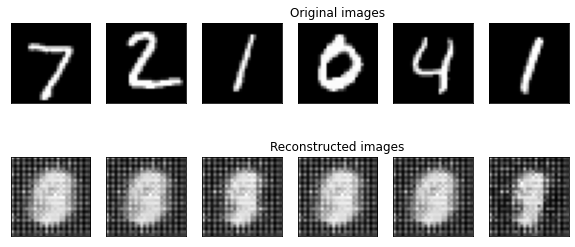

	 partial train loss (single batch): 16957.150391
	 partial train loss (single batch): 16580.685547
	 partial train loss (single batch): 17026.074219
	 partial train loss (single batch): 16934.476562
	 partial train loss (single batch): 16581.861328
	 partial train loss (single batch): 16512.359375
	 partial train loss (single batch): 16451.238281
	 partial train loss (single batch): 16648.275391
	 partial train loss (single batch): 16192.568359
	 partial train loss (single batch): 16805.994141
	 partial train loss (single batch): 16335.446289
	 partial train loss (single batch): 16559.017578
	 partial train loss (single batch): 16458.208984
	 partial train loss (single batch): 16241.865234
	 partial train loss (single batch): 16275.149414
	 partial train loss (single batch): 16228.107422
	 partial train loss (single batch): 16344.012695
	 partial train loss (single batch): 16456.191406
	 partial train loss (single batch): 16472.587891
	 partial train loss (single batch): 16110.576172


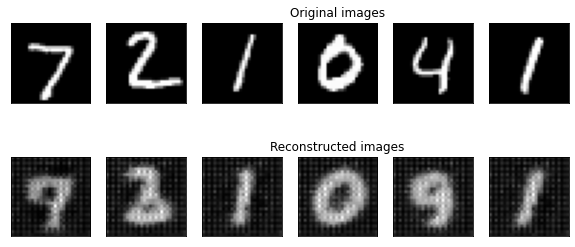

	 partial train loss (single batch): 12646.086914
	 partial train loss (single batch): 12778.140625
	 partial train loss (single batch): 12711.291992
	 partial train loss (single batch): 12721.204102
	 partial train loss (single batch): 12492.408203
	 partial train loss (single batch): 12767.069336
	 partial train loss (single batch): 13049.222656
	 partial train loss (single batch): 12814.539062
	 partial train loss (single batch): 12820.643555
	 partial train loss (single batch): 12723.527344
	 partial train loss (single batch): 12698.976562
	 partial train loss (single batch): 12654.550781
	 partial train loss (single batch): 12998.619141
	 partial train loss (single batch): 12533.368164
	 partial train loss (single batch): 12296.651367
	 partial train loss (single batch): 12504.784180
	 partial train loss (single batch): 12316.557617
	 partial train loss (single batch): 12637.150391
	 partial train loss (single batch): 12325.648438
	 partial train loss (single batch): 12497.001953


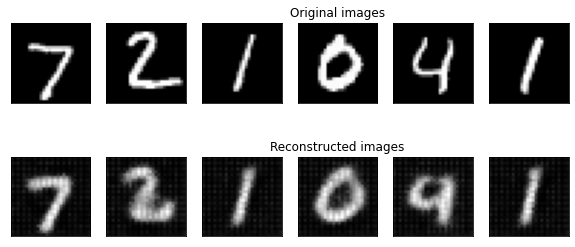

	 partial train loss (single batch): 10188.862305
	 partial train loss (single batch): 10497.753906
	 partial train loss (single batch): 10165.454102
	 partial train loss (single batch): 10285.711914
	 partial train loss (single batch): 10151.856445
	 partial train loss (single batch): 10546.878906
	 partial train loss (single batch): 10319.846680
	 partial train loss (single batch): 10119.724609
	 partial train loss (single batch): 10320.851562
	 partial train loss (single batch): 10117.166016
	 partial train loss (single batch): 10236.638672
	 partial train loss (single batch): 10391.993164
	 partial train loss (single batch): 10421.313477
	 partial train loss (single batch): 10220.038086
	 partial train loss (single batch): 10324.990234
	 partial train loss (single batch): 10069.164062
	 partial train loss (single batch): 10243.921875
	 partial train loss (single batch): 10734.002930
	 partial train loss (single batch): 10381.546875
	 partial train loss (single batch): 10297.858398


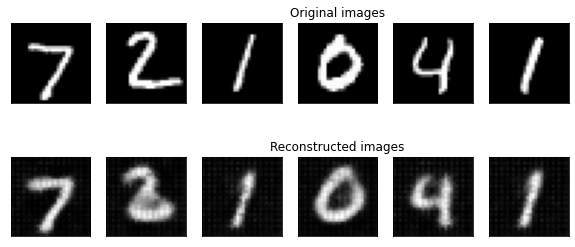

	 partial train loss (single batch): 9465.720703
	 partial train loss (single batch): 9399.721680
	 partial train loss (single batch): 9472.392578
	 partial train loss (single batch): 9298.911133
	 partial train loss (single batch): 9732.711914
	 partial train loss (single batch): 9961.281250
	 partial train loss (single batch): 9461.203125
	 partial train loss (single batch): 10081.234375
	 partial train loss (single batch): 9977.442383
	 partial train loss (single batch): 9757.064453
	 partial train loss (single batch): 9625.146484
	 partial train loss (single batch): 9478.843750
	 partial train loss (single batch): 9734.072266
	 partial train loss (single batch): 9611.148438
	 partial train loss (single batch): 10043.047852
	 partial train loss (single batch): 9415.026367
	 partial train loss (single batch): 9928.950195
	 partial train loss (single batch): 10133.666992
	 partial train loss (single batch): 9684.320312
	 partial train loss (single batch): 9606.623047
	 partial train l

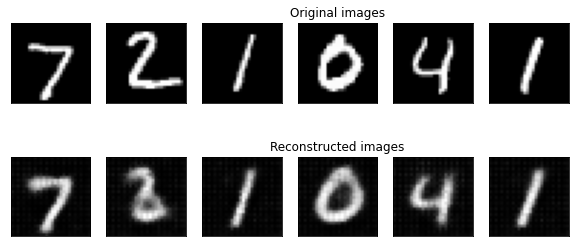

In [29]:
num_epochs = 5

for epoch in range(num_epochs):
   train_loss = train_epoch(model, trainloader,optim)
   val_loss = test_epoch(model, valloader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   plot_ae_outputs(model.encoder, model.decoder,n=6)




In [30]:
encoded_samples = []
for sample in tqdm(testset):
    img = sample[0].unsqueeze(0)
    label = sample[1]
    # Encode image
    model.eval()
    with torch.no_grad():
        encoded_img  = model.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

100%|██████████| 10000/10000 [00:08<00:00, 1222.97it/s]


In [31]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()